In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.colors import rgb2hex

In [2]:
nm= pd.read_csv("mx/IHME_USA_COUNTY_CVD_MORTALITY_RATES_1980_2014_NEW MEXICO_Y2017M05D16.CSV")

In [3]:
nm.columns.values

array(['measure_id', 'measure_name', 'location_id', 'location_name',
       'FIPS', 'cause_id', 'cause_name', 'sex_id', 'sex', 'age_id',
       'age_name', 'year_id', 'metric', 'mx', 'upper', 'lower'], dtype=object)

In [4]:
n1=nm[["FIPS","location_name","cause_id","cause_name","sex","year_id","mx"]]

In [5]:
n2=n1[(n1["location_name"]=="New Mexico") & (n1["sex"]=="Male")]

In [6]:
causes=nm[["cause_id","cause_name"]].drop_duplicates().reset_index()[["cause_id","cause_name"]]

In [7]:
locations=nm[["FIPS","location_name"]].drop_duplicates().reset_index()[["FIPS","location_name"]]

In [8]:
locations.head()

,FIPS,location_name
0,35,New Mexico
1,35001,Bernalillo County
2,35003,Catron County
3,35005,Chaves County
4,35006,Cibola County


In [9]:
causes

,cause_id,cause_name
0,491,Cardiovascular diseases
1,492,Rheumatic heart disease
2,493,Ischemic heart disease
3,494,Cerebrovascular disease
4,495,Ischemic stroke
5,496,Hemorrhagic stroke
6,498,Hypertensive heart disease
7,499,Cardiomyopathy and myocarditis
8,500,Atrial fibrillation and flutter
9,501,Aortic aneurysm


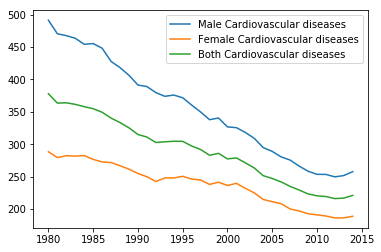

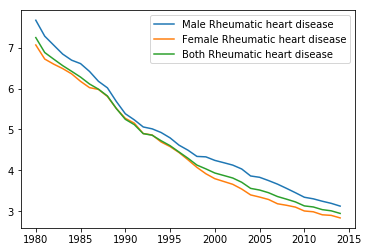

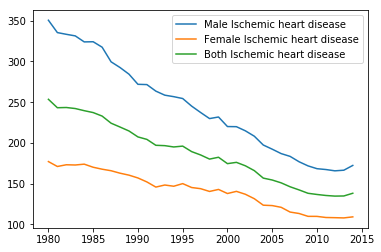

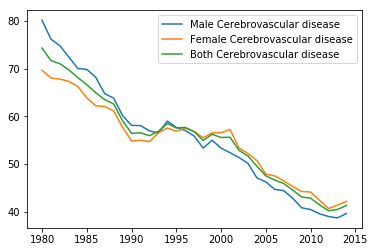

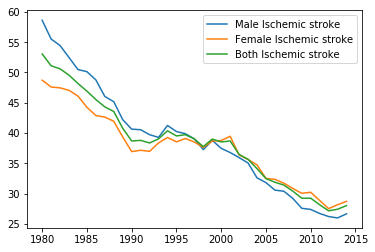

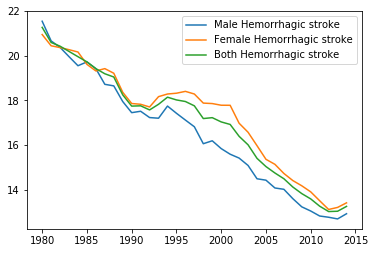

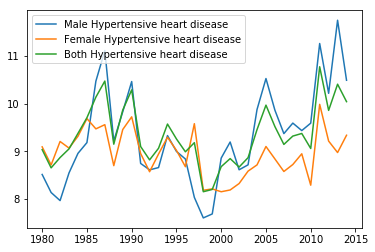

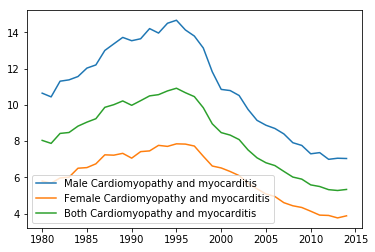

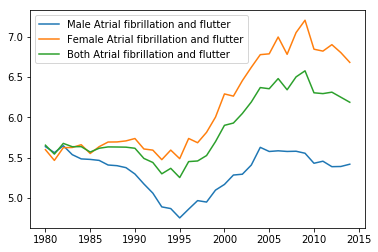

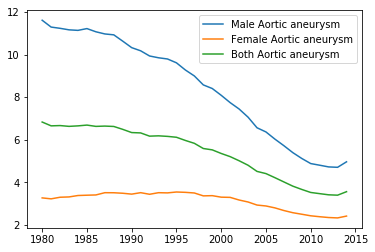

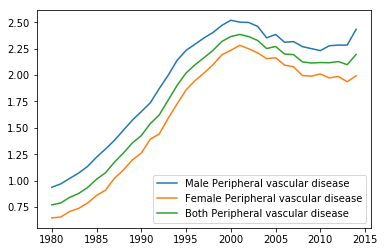

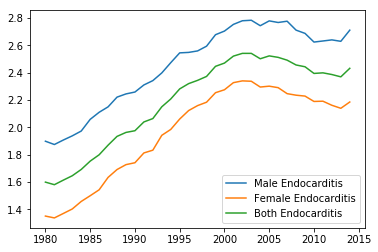

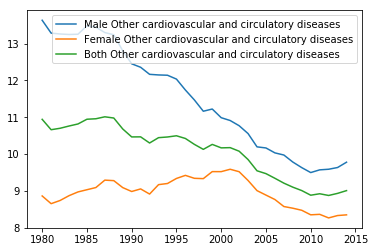

In [10]:
### to show different disease mortality rate trend from 1980-2014 in NM
## it's interesting that not all of them goes down with the over time.
for index,row in causes.iterrows():
    #plt.subplot(5,3,index+1)
    n2=n1[(n1["location_name"]=="New Mexico") & (n1["sex"]=="Male") & (n1["cause_id"]==row["cause_id"])]
    plt.plot(n2["year_id"], n2["mx"],label="Male "+row["cause_name"])
    n3=n1[(n1["location_name"]=="New Mexico") & (n1["sex"]=="Female") & (n1["cause_id"]==row["cause_id"])]
    #plt.title=row["cause_name"]
    plt.plot(n3["year_id"], n3["mx"],label="Female "+row["cause_name"])
    n4=n1[(n1["location_name"]=="New Mexico") & (n1["sex"]=="Both") & (n1["cause_id"]==row["cause_id"])]
    #plt.title=row["cause_name"]
    plt.plot(n4["year_id"], n4["mx"],label="Both "+row["cause_name"])
    plt.legend()
    plt.show()

    

In [11]:
from mpl_toolkits.basemap import Basemap

In [12]:
area=nm[(nm["sex"]=="Male") & (nm["cause_id"]==491) & (nm["year_id"]==2014)]

In [13]:
len(area)

34

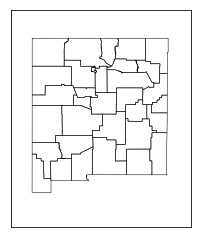

In [14]:
#draw a new mexico map with counties.
m = Basemap(resolution='i',projection = 'merc', llcrnrlat=30, urcrnrlat=38,
        llcrnrlon=-110, urcrnrlon=-102)
m.readshapefile('shapefiles/NM_counties', 'nm')
plt.show()

In [15]:
area[["location_name","mx"]].head()

,location_name,mx
34,New Mexico,257.877869
139,Bernalillo County,258.893719
244,Catron County,187.628774
349,Chaves County,298.210889
454,Cibola County,256.749879


In [16]:
income=pd.read_csv("NM_income.csv")

In [17]:
income.head()

,County,Per Capita Income,Median Household,Median Family Income,Population,Households
0,Los Alamos,49474,103643,118993,17950,7663
1,Santa Fe,32188,52696,64041,144170,61963
2,Bernalillo,26143,47481,59809,662564,266000
3,Sandoval,25979,57158,65906,131561,47602
4,Eddy,24587,46583,56646,53829,20411


In [18]:
income.County=income.apply(lambda row: row["County"] if (row["County"] =="New Mexico") else row["County"]+" County",axis=1)

In [19]:
income=income.merge(locations, left_on="County", right_on="location_name", how="left")

In [20]:
income.head()

,County,Per Capita Income,Median Household,Median Family Income,Population,Households,FIPS,location_name
0,Los Alamos County,49474,103643,118993,17950,7663,35028,Los Alamos County
1,Santa Fe County,32188,52696,64041,144170,61963,35049,Santa Fe County
2,Bernalillo County,26143,47481,59809,662564,266000,35001,Bernalillo County
3,Sandoval County,25979,57158,65906,131561,47602,35043,Sandoval County
4,Eddy County,24587,46583,56646,53829,20411,35015,Eddy County


In [21]:
#data with FIPS info, and label of data to draw.
def drawNMcounties(data, label):
    m = Basemap(resolution='i',projection = 'merc', llcrnrlat=30, urcrnrlat=38,
            llcrnrlon=-110, urcrnrlon=-102)
    m.readshapefile('shapefiles/NM_counties', 'nm')
    cmap = plt.get_cmap("Greens")
    mx_min=data[label].min()
    mx_max=data[label].max()
    df_poly = pd.DataFrame({
        'shapes': [np.array(shape) for shape in m.nm],
        'GEOID': [area['GEOID'] for area in m.nm_info]
    })
    df_poly.GEOID = pd.to_numeric(df_poly.GEOID , errors='coerce')
    df_poly=df_poly.merge(data, left_on='GEOID', right_on="FIPS", how='left')
    df_poly["color"]=df_poly.apply(lambda row: rgb2hex(cmap(np.sqrt((row[label]-mx_min)/(mx_max-mx_min)))[:3]),     axis=1)
    ax = plt.gca()
    for index,row in df_poly.iterrows():
        poly = Polygon(list(row["shapes"]),facecolor=row["color"],edgecolor=row["color"])
        ax.add_patch(poly)
    #plt.colorbar(m, shrink=0.4)
    mapper = matplotlib.cm.ScalarMappable(cmap=cmap)
    mapper.set_array(data[label])
    plt.colorbar(mapper,shrink=0.8)
    plt.show()  

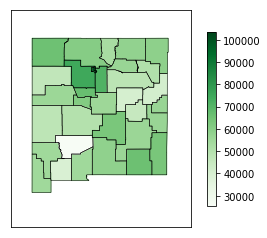

In [22]:
drawNMcounties(income, "Median Household")

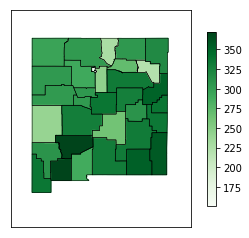

In [23]:
drawNMcounties(area, "mx")

In [24]:
len(area)

34

In [25]:
area2=area.merge(income,on="FIPS",how="left")


In [26]:
area2=area2.drop([0,11])

In [27]:
area2=area2[area2["Population"]> 20000]

In [28]:
len(area2)

19

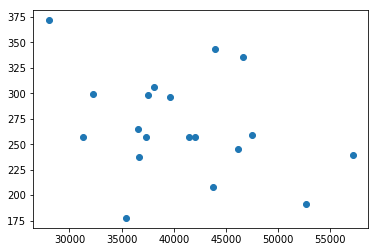

In [29]:
plt.scatter(area2["Median Household"],area2["mx"])
plt.show()

In [30]:
area2[area2["mx"]< 200]

,measure_id,measure_name,location_id,location_name_x,FIPS,cause_id,cause_name,sex_id,sex,age_id,...,mx,upper,lower,County,Per Capita Income,Median Household,Median Family Income,Population,Households,location_name_y
27,1,Deaths,2375,Santa Fe County,35049,491,Cardiovascular diseases,1,Male,27,...,191.094231,204.655516,178.936552,Santa Fe County,32188,52696,64041,144170,61963,Santa Fe County
30,1,Deaths,2370,Taos County,35055,491,Cardiovascular diseases,1,Male,27,...,177.598733,195.636453,161.302452,Taos County,22145,35441,43236,32937,14806,Taos County


In [31]:
t1=nm[(nm["sex"]=="Male") & (nm["cause_id"]==491) & (nm["year_id"]==2010)]

In [32]:
t1=t1.merge(income, on="FIPS",how="left")


In [33]:
t1=t1[t1["Population"]> 10000]

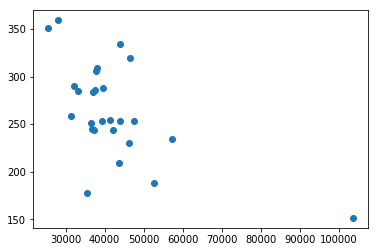

In [34]:
plt.scatter(t1["Median Household"],t1["mx"])
plt.show()

In [35]:
#exploring the relation of mortality rate and poverty rate
poverty=pd.read_csv("NM_poverty.csv")

In [36]:
poverty.County=poverty.apply(lambda row: row.County+ " County",axis=1)

In [37]:
poverty.head()

,County,Poverty
0,Bernalillo County,18.0
1,Catron County,19.7
2,Chaves County,21.3
3,Cibola County,27.6
4,Colfax County,17.7


In [38]:
poverty=poverty.merge(locations, left_on="County",right_on="location_name", how="left")

In [39]:
t1=nm[(nm["sex"]=="Male") & (nm["cause_id"]==491) & (nm["year_id"]==2010)]

In [40]:
t1=t1.merge(poverty, on="FIPS",how="left")

In [41]:
t1=t1.drop(0)

In [42]:
t1.columns.values

array(['measure_id', 'measure_name', 'location_id', 'location_name_x',
       'FIPS', 'cause_id', 'cause_name', 'sex_id', 'sex', 'age_id',
       'age_name', 'year_id', 'metric', 'mx', 'upper', 'lower', 'County',
       ' Poverty', 'location_name_y'], dtype=object)

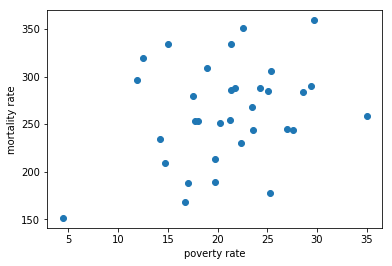

In [43]:
plt.scatter(t1[" Poverty"],t1["mx"])
plt.xlabel("poverty rate")
plt.ylabel("mortality rate")
plt.show()

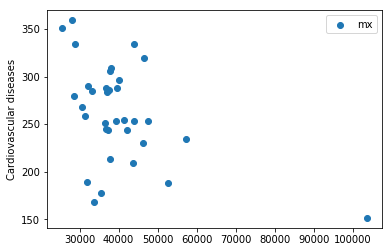

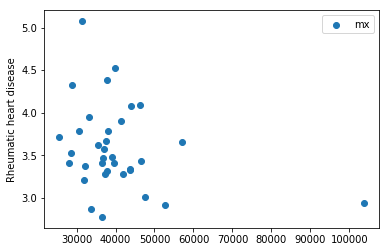

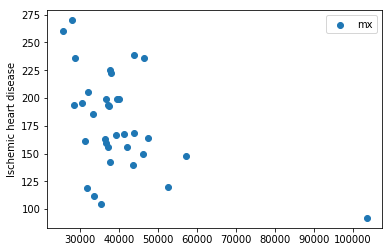

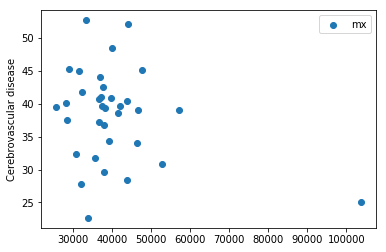

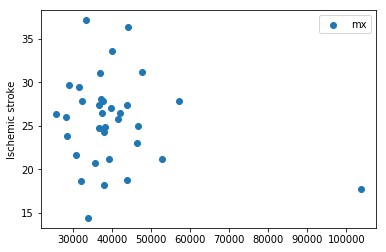

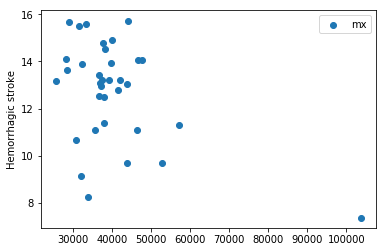

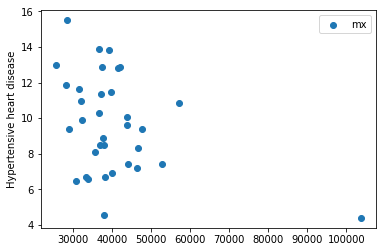

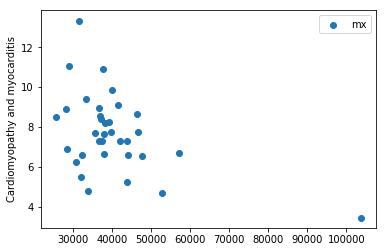

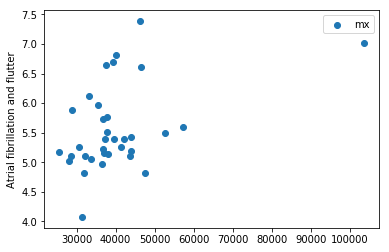

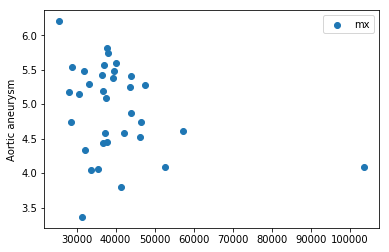

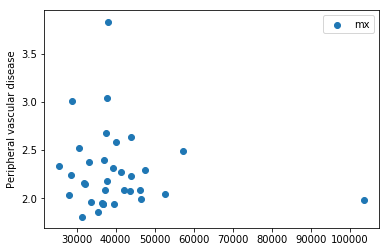

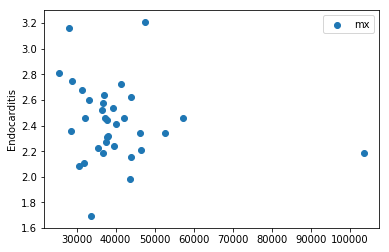

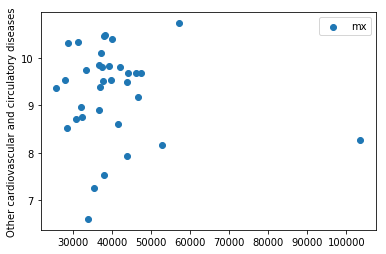

In [44]:
# explore the relationship between mortality rate and income
# the correlation is not clear.

for index,row in causes.iterrows():
    #plt.subplot(5,3,index+1)
    #n2=n1[(n1["location_name"]=="New Mexico") & (n1["sex"]=="Male") & (n1["cause_id"]==row["cause_id"])]
    t1=nm[(nm["sex"]=="Male") & (nm["cause_id"]==row["cause_id"]) & (nm["year_id"]==2010)]
    t1=t1.merge(income, on="FIPS",how="left")
    plt.scatter(t1["Median Household"],t1["mx"])
    #plt.xlabel("Median Household income")
    plt.ylabel(row["cause_name"])
    plt.legend()
    plt.show()